In [1]:
!pip install lifetimes jcopml sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes.utils import summary_data_from_transaction_data
from jcopml.plot import plot_missing_value

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [3]:
df = pd.read_csv('http://raw.githubusercontent.com/nahwan25/Machine-Learning/refs/heads/main/Customersegmentation2/Dataset/Customer%20Segmentation.txt', delimiter="\t")
df.head()

,Customer_ID,Nama Pelanggan,Jenis Kelamin,Umur,Profesi,Tipe Residen,NilaiBelanjaSetahun
0,CUST-001,Budi Anggara,Pria,58,Wiraswasta,Sector,9497927
1,CUST-002,Shirley Ratuwati,Wanita,14,Pelajar,Cluster,2722700
2,CUST-003,Agus Cahyono,Pria,48,Professional,Cluster,5286429
3,CUST-004,Antonius Winarta,Pria,53,Professional,Cluster,5204498
4,CUST-005,"Ibu Sri Wahyuni, IR",Wanita,41,Wiraswasta,Cluster,10615206


EDA

In [4]:
df.dtypes

Customer_ID            object
Nama Pelanggan         object
Jenis Kelamin          object
Umur                    int64
Profesi                object
Tipe Residen           object
NilaiBelanjaSetahun     int64
dtype: object

,missing_value,%
Customer_ID,0,0.0
Nama Pelanggan,0,0.0
Jenis Kelamin,0,0.0
Umur,0,0.0
Profesi,0,0.0
Tipe Residen,0,0.0
NilaiBelanjaSetahun,0,0.0


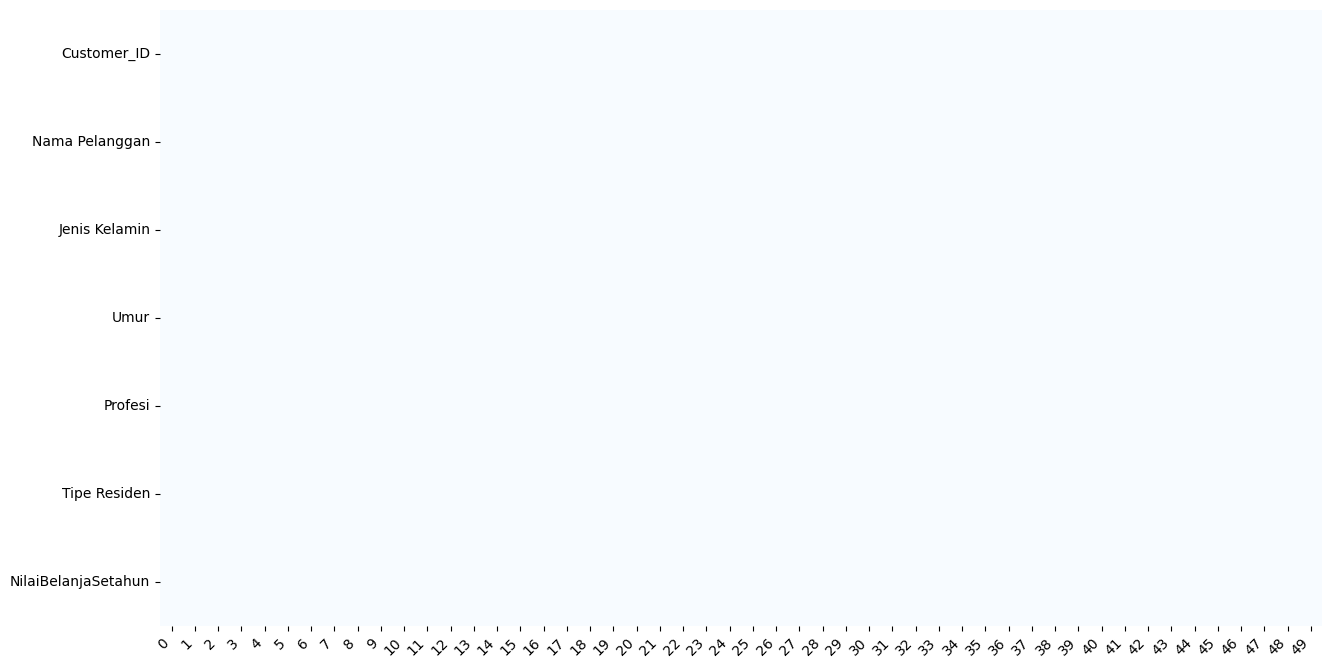

In [5]:
plot_missing_value(df, return_df = True)

In [6]:
df.describe()

,Umur,NilaiBelanjaSetahun
count,50.000000,5.000000e+01
mean,37.500000,7.069875e+06
std,14.673661,2.590619e+06
min,14.000000,2.722700e+06
25%,25.000000,5.257530e+06
50%,35.000000,5.980077e+06
75%,49.750000,9.739615e+06
max,64.000000,1.088451e+07


Dari variabel numerik ini saya akan melakukan segmentasi pelanggan berdasarkan umur dan nilai belanja setahun

Nilai belanja tahunan juga cukup bervariasi, dari min 2.72 juta hingga max 10.88 juta, mungkin ada pelanggan dengan spending yang jauh lebih tinggi dari yang lain, yang bisa dikategorikan sebagai VIP customers

Saya juga akan mengecek apakah umur punya hubungan signifikan dengan pengeluaran pelanggan

Identifikasi Outlier

Outlier Umur

In [7]:
q1_quan = df['Umur'].quantile(0.25)
q3_quan = df['Umur'].quantile(0.75)
iqr_quan = q3_quan - q1_quan
lb_quan = float(q1_quan) - (1.5 * iqr_quan)
ub_quan = float(q3_quan) + (1.5 * iqr_quan)

print('Q1 = {}'.format(q1_quan))
print('Q3 = {}'.format(q3_quan))
print('IQR = Q3 - Q1 = {}'.format(iqr_quan))
print('lower bound = Q1 - 1.5 * IQR = {}'.format(lb_quan))
print('upper bound = Q3 + 1.5 * IQR = {}'.format(ub_quan))

Q1 = 25.0
Q3 = 49.75
IQR = Q3 - Q1 = 24.75
lower bound = Q1 - 1.5 * IQR = -12.125
upper bound = Q3 + 1.5 * IQR = 86.875


Outlier Nilai Belanja Setahun

In [8]:
q1_unit = df['NilaiBelanjaSetahun'].quantile(0.25)
q3_unit = df['NilaiBelanjaSetahun'].quantile(0.75)
iqr_unit = q3_unit - q1_unit 
lb_unit = float(q1_unit) - (1.5 * iqr_unit)
ub_unit = float(q3_unit) + (1.5 * iqr_unit)

print('Q1 = {}'.format(q1_unit))
print('Q3 = {}'.format(q3_unit))
print('IQR = Q3 - Q1 = {}'.format(iqr_unit))
print('lower bound = Q1 - 1.5 * IQR = {}'.format(lb_unit))
print('upper bound = Q1 - 1.5 * IQR = {}'.format(ub_unit))

Q1 = 5257529.75
Q3 = 9739615.0
IQR = Q3 - Q1 = 4482085.25
lower bound = Q1 - 1.5 * IQR = -1465598.125
upper bound = Q1 - 1.5 * IQR = 16462742.875


Hubungan antara Umur dan Nilai Belanja Setahun

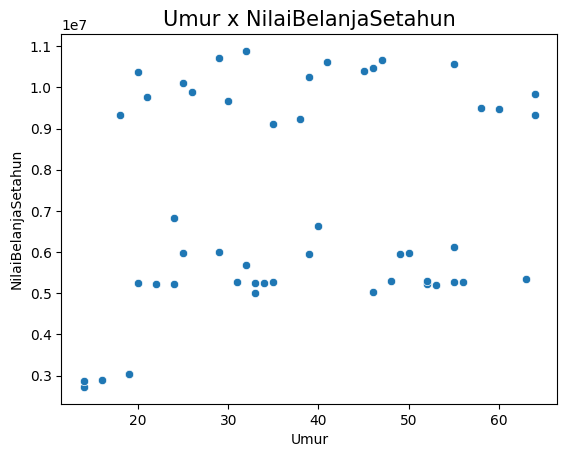

In [9]:
sns.scatterplot(x=df['Umur'], y=df['NilaiBelanjaSetahun'])
plt.title('Umur x NilaiBelanjaSetahun', fontsize=15)
plt.show()

Scatter plot di atas makin jelas hubungan antar kedua kolom
- Umur dibawah 20 tahun, Nilai belanja per tahunya itu 2 jutaan sampai dengan 3 jutaan
- Umur dengan lebih dari 20 tahun, ada 2 Nilai Belanja, Nilai belanja yang pertama 5-7 jutaan dan 9-11 jutaan

Umur -> Q1: 25.0, Q3: 49.75, IQR: 24.75, LB: -12.125, UB: 86.875
NilaiBelanjaSetahun -> Q1: 5257529.75, Q3: 9739615.0, IQR: 4482085.25, LB: -1465598.125, UB: 16462742.875


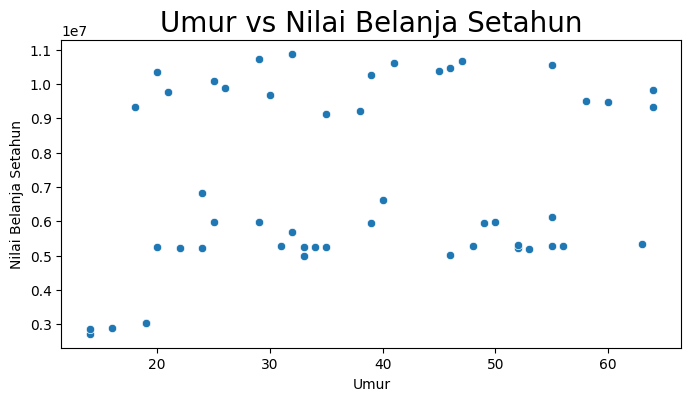

In [10]:
print(f"Umur -> Q1: {q1_quan}, Q3: {q3_quan}, IQR: {iqr_quan}, LB: {lb_quan}, UB: {ub_quan}")
print(f"NilaiBelanjaSetahun -> Q1: {q1_unit}, Q3: {q3_unit}, IQR: {iqr_unit}, LB: {lb_unit}, UB: {ub_unit}")

df_filtered = df[
    (df['Umur'] >= lb_quan) & (df['Umur'] <= ub_quan) &
    (df['NilaiBelanjaSetahun'] >= lb_unit) & (df['NilaiBelanjaSetahun'] <= ub_unit)
]

# Visualisasi scatter plot
plt.figure(figsize=(8, 4))
sns.scatterplot(x=df_filtered['Umur'], y=df_filtered['NilaiBelanjaSetahun'])
plt.title('Umur vs Nilai Belanja Setahun', fontsize=20)
plt.xlabel('Umur')
plt.ylabel('Nilai Belanja Setahun')
plt.show()

Distribusi Umur dan Nilai Belanja Setahun

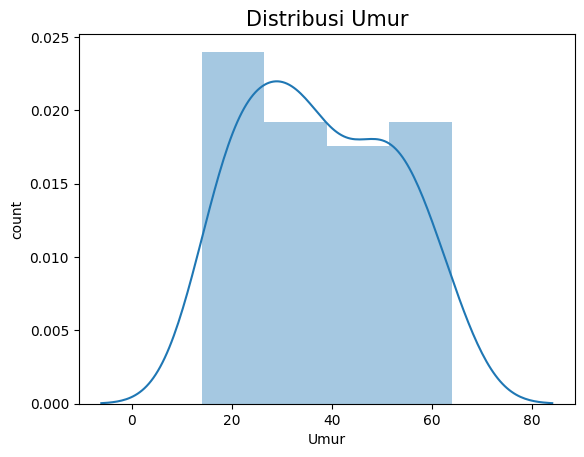

In [11]:
sns.distplot(df['Umur'])
plt.title('Distribusi Umur', fontsize = 15)
plt.xlabel('Umur')
plt.ylabel('count');

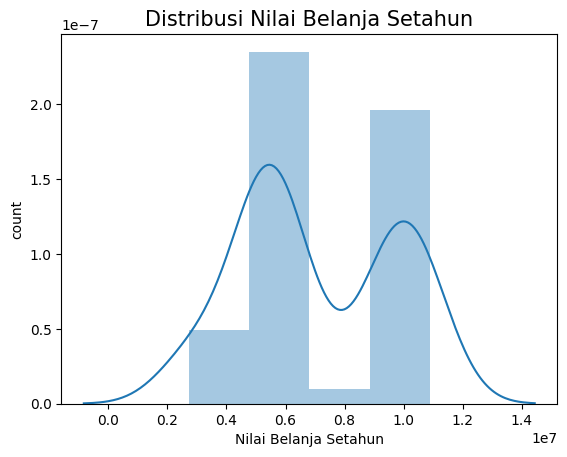

In [12]:
sns.distplot(df['NilaiBelanjaSetahun'])
plt.title('Distribusi Nilai Belanja Setahun', fontsize = 15)
plt.xlabel('Nilai Belanja Setahun')
plt.ylabel('count');

Plot profesi dan tipe residen terbanyak

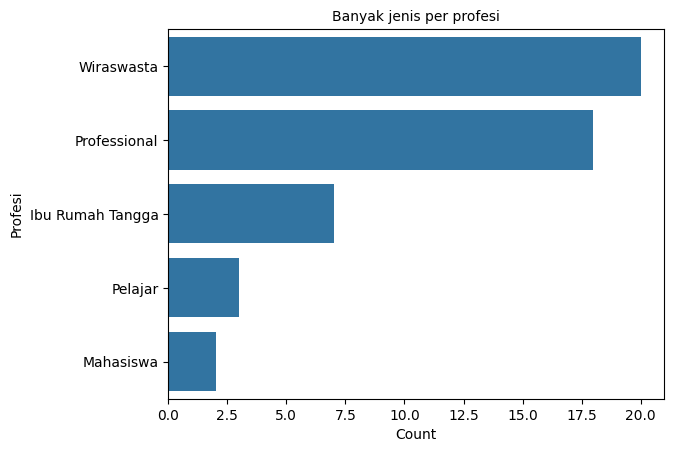

In [13]:
x = df['Profesi'].value_counts().head(5)
sns.barplot(x = x.values, y = x.index, )
plt.title('Banyak jenis per profesi', fontsize = 10)
plt.xlabel('Count')
plt.ylabel('Profesi');

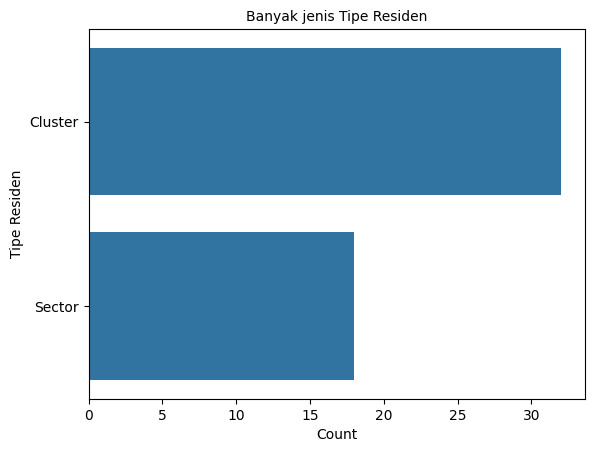

In [14]:
x = df['Tipe Residen'].value_counts().head(5)
sns.barplot(x = x.values, y = x.index, )
plt.title('Banyak jenis Tipe Residen', fontsize = 10)
plt.xlabel('Count')
plt.ylabel('Tipe Residen');

Berikut detil jumlah Profesi dan jumlah transaksi yang terjadi

In [15]:
x = df['Profesi'].nunique()
print("Terdapat total {} negara".format(x))

Profesi = pd.DataFrame(df['Profesi'].value_counts()).reset_index()
Profesi.columns = ['Profesi', 'Jumlah Transaksi']
Profesi

Terdapat total 5 negara


,Profesi,Jumlah Transaksi
0,Wiraswasta,20
1,Professional,18
2,Ibu Rumah Tangga,7
3,Pelajar,3
4,Mahasiswa,2


Customer Segmentation

Kelompok Umur:
- Muda (≤ 25 tahun)
- Dewasa (26 - 49 tahun)
- Lansia (≥ 50 tahun)

Kelompok Spending Behavior (berdasarkan kuartil):
- Low Spender: < 5.25 juta
- Medium Spender: 5.25 juta - 9.73 juta
- High Spender: > 9.73 juta

In [16]:
# 1. Membuat kategori Umur
def kategori_umur(umur):
    if umur <= 25:
        return "Muda"
    elif 26 <= umur <= 49:
        return "Dewasa"
    else:
        return "Lansia"

df['Kategori_Umur'] = df['Umur'].apply(kategori_umur)

# 2. Membuat kategori Spending berdasarkan kuartil
def kategori_spending(nilai):
    if nilai < 5257530:
        return "Low Spender"
    elif 5257530 <= nilai <= 9739615:
        return "Medium Spender"
    else:
        return "High Spender"

df['Kategori_Spending'] = df['NilaiBelanjaSetahun'].apply(kategori_spending)

# Menampilkan hasil
print(df.head())

  Customer_ID       Nama Pelanggan Jenis Kelamin  Umur       Profesi  \
0    CUST-001         Budi Anggara          Pria    58    Wiraswasta   
1    CUST-002     Shirley Ratuwati        Wanita    14       Pelajar   
2    CUST-003         Agus Cahyono          Pria    48  Professional   
3    CUST-004     Antonius Winarta          Pria    53  Professional   
4    CUST-005  Ibu Sri Wahyuni, IR        Wanita    41    Wiraswasta   

  Tipe Residen  NilaiBelanjaSetahun Kategori_Umur Kategori_Spending  
0       Sector              9497927        Lansia    Medium Spender  
1      Cluster              2722700          Muda       Low Spender  
2      Cluster              5286429        Dewasa    Medium Spender  
3      Cluster              5204498        Lansia       Low Spender  
4      Cluster             10615206        Dewasa      High Spender  


In [17]:
scaler = StandardScaler()
df[['Umur', 'NilaiBelanjaSetahun']] = scaler.fit_transform(df[['Umur', 'NilaiBelanjaSetahun']])
print(df.head())

  Customer_ID       Nama Pelanggan Jenis Kelamin      Umur       Profesi  \
0    CUST-001         Budi Anggara          Pria  1.411245    Wiraswasta   
1    CUST-002     Shirley Ratuwati        Wanita -1.617768       Pelajar   
2    CUST-003         Agus Cahyono          Pria  0.722833  Professional   
3    CUST-004     Antonius Winarta          Pria  1.067039  Professional   
4    CUST-005  Ibu Sri Wahyuni, IR        Wanita  0.240944    Wiraswasta   

  Tipe Residen  NilaiBelanjaSetahun Kategori_Umur Kategori_Spending  
0       Sector             0.946763        Lansia    Medium Spender  
1      Cluster            -1.695081          Muda       Low Spender  
2      Cluster            -0.695414        Dewasa    Medium Spender  
3      Cluster            -0.727361        Lansia       Low Spender  
4      Cluster             1.382421        Dewasa      High Spender  


In [18]:
df_Hybrid_Segmentation = df[["Customer_ID", 'Umur', 'NilaiBelanjaSetahun']]

In [19]:
df_Hybrid_Segmentation.head()

,Customer_ID,Umur,NilaiBelanjaSetahun
0,CUST-001,1.411245,0.946763
1,CUST-002,-1.617768,-1.695081
2,CUST-003,0.722833,-0.695414
3,CUST-004,1.067039,-0.727361
4,CUST-005,0.240944,1.382421


In [20]:
df_selected = df_Hybrid_Segmentation[['Umur', 'NilaiBelanjaSetahun']]

n_clusters_options = [2, 3, 4, 5, 6]  
linkage_options = ['ward', 'complete', 'average', 'single']
affinity_options = ['euclidean', 'manhattan', 'cosine']

best_score = -1
best_params = {}

for n_clusters in n_clusters_options:
    for linkage in linkage_options:
        for affinity in affinity_options:
            # 'ward' hanya mendukung 'euclidean'
            if linkage == 'ward' and affinity != 'euclidean':
                continue
            try:
                # Model Agglomerative Clustering
                model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric=affinity)
                labels = model.fit_predict(df_selected)
                
                # Cek apakah jumlah cluster valid
                if len(np.unique(labels)) < 2:
                    continue
                
                # Hitung silhouette score
                score = silhouette_score(df_selected, labels, metric=affinity)
                print(f"n_clusters={n_clusters}, linkage={linkage}, affinity={affinity}, silhouette_score={score:.4f}")
                
                # Simpan parameter terbaik
                if score > best_score:
                    best_score = score
                    best_params = {"n_clusters": n_clusters, "linkage": linkage, "affinity": affinity}
            except Exception as e:
                print(f"Error with n_clusters={n_clusters}, linkage={linkage}, affinity={affinity}: {e}")

print("\nBest parameters:", best_params, "with silhouette score:", best_score)

n_clusters=2, linkage=ward, affinity=euclidean, silhouette_score=0.4442


n_clusters=2, linkage=complete, affinity=euclidean, silhouette_score=0.3628
n_clusters=2, linkage=complete, affinity=manhattan, silhouette_score=0.3818
n_clusters=2, linkage=complete, affinity=cosine, silhouette_score=0.6449
n_clusters=2, linkage=average, affinity=euclidean, silhouette_score=0.3485
n_clusters=2, linkage=average, affinity=manhattan, silhouette_score=0.4957
n_clusters=2, linkage=average, affinity=cosine, silhouette_score=0.6449
n_clusters=2, linkage=single, affinity=euclidean, silhouette_score=0.4442
n_clusters=2, linkage=single, affinity=manhattan, silhouette_score=0.4957
n_clusters=2, linkage=single, affinity=cosine, silhouette_score=0.6449
n_clusters=3, linkage=ward, affinity=euclidean, silhouette_score=0.4836
n_clusters=3, linkage=complete, affinity=euclidean, silhouette_score=0.3458
n_clusters=3, linkage=complete, affinity=manhattan, silhouette_score=0.3748
n_clusters=3, linkage=complete, affinity=cosine, silhouette_score=0.7710
n_clusters=3, linkage=average, affin

In [21]:
hierarchical_cluster = AgglomerativeClustering(n_clusters = 4, metric = 'cosine', linkage = 'complete')
labels = hierarchical_cluster.fit(df_selected)

pred_agc = pd.Series(hierarchical_cluster.labels_)
df_Hybrid_Segmentation['Class'] = pred_agc; df_Hybrid_Segmentation['Class'] = pred_agc

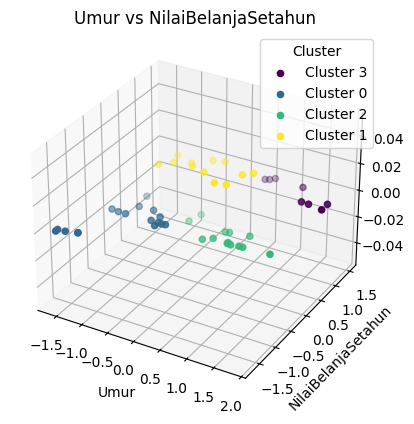

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.array(df_Hybrid_Segmentation['Umur'])
y = np.array(df_Hybrid_Segmentation['NilaiBelanjaSetahun'])
clusters = df_Hybrid_Segmentation['Class'].unique()

# Buat warna berbeda untuk setiap cluster
cmap = cm.get_cmap("viridis", len(clusters))
colors = {cluster: cmap(i) for i, cluster in enumerate(clusters)}

# Scatter plot dengan warna per cluster
for cluster in clusters:
    subset = df_Hybrid_Segmentation[df_Hybrid_Segmentation['Class'] == cluster]
    ax.scatter(subset['Umur'], subset['NilaiBelanjaSetahun'], c=[colors[cluster]], label=f'Cluster {cluster}')

# Tambahkan legenda
ax.legend(title="Cluster")

# Set label & title
plt.title('Umur vs NilaiBelanjaSetahun')
ax.set_xlabel('Umur')
ax.set_ylabel('NilaiBelanjaSetahun')

plt.show()


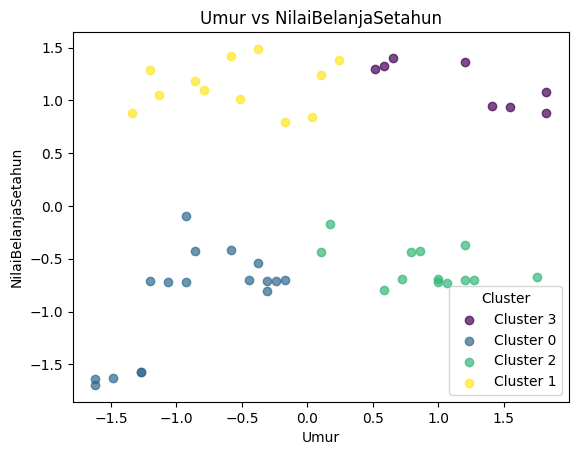

In [23]:
# Buat figure dan axis 2D
fig, ax = plt.subplots()

x = np.array(df_Hybrid_Segmentation['Umur'])
y = np.array(df_Hybrid_Segmentation['NilaiBelanjaSetahun'])
clusters = df_Hybrid_Segmentation['Class'].unique()

cmap = cm.get_cmap("viridis", len(clusters))
colors = {cluster: cmap(i) for i, cluster in enumerate(clusters)}

for cluster in clusters:
    subset = df_Hybrid_Segmentation[df_Hybrid_Segmentation['Class'] == cluster]
    ax.scatter(subset['Umur'], subset['NilaiBelanjaSetahun'], 
               c=[colors[cluster]], label=f'Cluster {cluster}', alpha=0.7)

ax.legend(title="Cluster")

plt.title('Umur vs NilaiBelanjaSetahun')
ax.set_xlabel('Umur')
ax.set_ylabel('NilaiBelanjaSetahun')

plt.show()

In [24]:
# 1. Membuat kategori Umur
def kategori_umur(umur):
    if umur <= 25:
        return "Muda"
    elif 26 <= umur <= 49:
        return "Dewasa"
    else:
        return "Lansia"

df_Hybrid_Segmentation['Kategori_Umur'] = df_Hybrid_Segmentation['Umur'].apply(kategori_umur)

# 2. Membuat kategori Spending berdasarkan kuartil
def kategori_spending(nilai):
    if nilai < 5257530:
        return "Low Spender"
    elif 5257530 <= nilai <= 9739615:
        return "Medium Spender"
    else:
        return "High Spender"

df_Hybrid_Segmentation['Kategori_Spending'] = df_Hybrid_Segmentation['NilaiBelanjaSetahun'].apply(kategori_spending)

# Menampilkan hasil
print(df_Hybrid_Segmentation.head())

  Customer_ID      Umur  NilaiBelanjaSetahun  Class Kategori_Umur  \
0    CUST-001  1.411245             0.946763      3          Muda   
1    CUST-002 -1.617768            -1.695081      0          Muda   
2    CUST-003  0.722833            -0.695414      2          Muda   
3    CUST-004  1.067039            -0.727361      2          Muda   
4    CUST-005  0.240944             1.382421      1          Muda   

  Kategori_Spending  
0       Low Spender  
1       Low Spender  
2       Low Spender  
3       Low Spender  
4       Low Spender  


In [25]:
cluster_names = {
    0: "Young Low Spender",
    1: "Young High Spender",
    2: "Older Low Spender",
    3: "Older High Spender"
}

df_Hybrid_Segmentation["Class"] = df_Hybrid_Segmentation["Class"].map(cluster_names)
print(df_Hybrid_Segmentation.head())

  Customer_ID      Umur  NilaiBelanjaSetahun               Class  \
0    CUST-001  1.411245             0.946763  Older High Spender   
1    CUST-002 -1.617768            -1.695081   Young Low Spender   
2    CUST-003  0.722833            -0.695414   Older Low Spender   
3    CUST-004  1.067039            -0.727361   Older Low Spender   
4    CUST-005  0.240944             1.382421  Young High Spender   

  Kategori_Umur Kategori_Spending  
0          Muda       Low Spender  
1          Muda       Low Spender  
2          Muda       Low Spender  
3          Muda       Low Spender  
4          Muda       Low Spender  


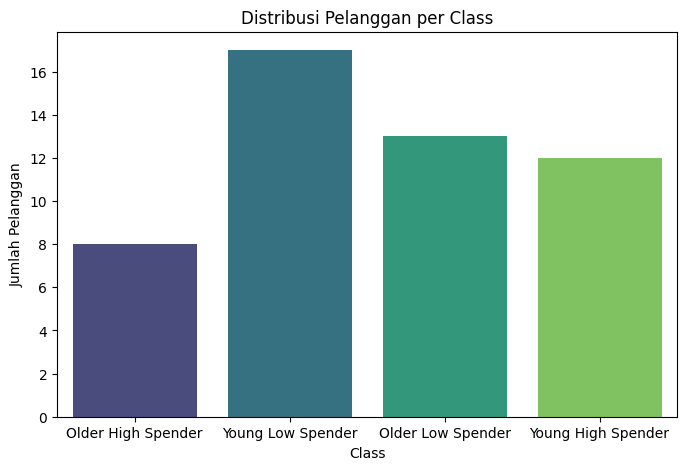

In [26]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Class', data=df_Hybrid_Segmentation, palette="viridis")
plt.xlabel("Class")
plt.ylabel("Jumlah Pelanggan")
plt.title("Distribusi Pelanggan per Class")
plt.show()

Berdasarkan distribusi pelanggan per segmen pada grafik, berikut beberapa insight untuk strategi bisnis:

Young Low Spender (Paling Banyak)
Strategi:
- Pelanggan muda dengan pengeluaran rendah adalah kelompok terbesar.
- Bisa ditargetkan dengan promosi diskon, program cashback, atau paket bundling untuk mendorong lebih banyak pembelian.
- Bisa juga diberikan insentif seperti loyalty points agar mereka lebih sering belanja.

Older Low Spender (Cukup Banyak)
Strategi:
- Pelanggan lebih tua tetapi dengan pengeluaran rendah.
- Bisa ditingkatkan dengan produk atau layanan yang sesuai dengan kebutuhan mereka, misalnya promo berbasis kebutuhan harian.
- Strategi pemasaran yang lebih personal seperti newsletter dengan rekomendasi produk berdasarkan histori pembelian.

Young High Spender (Sedang)
Strategi:
- Mereka memiliki daya beli tinggi, artinya sudah loyal terhadap produk.
- Bisa diberikan program VIP atau eksklusif untuk meningkatkan loyalitas mereka.
- Memberikan pengalaman premium seperti layanan pelanggan yang lebih baik atau penawaran eksklusif.

Older High Spender (Paling Sedikit)
Strategi:
- Kelompok ini berharga karena mereka mengeluarkan banyak uang meskipun jumlahnya sedikit.
- Fokus pada layanan premium, produk berkualitas tinggi, atau pengalaman belanja eksklusif.
- Bisa dilakukan pendekatan dengan marketing berbasis rekomendasi personal dan layanan pelanggan khusus.

Kesimpulan Strategi Bisnis
- Fokus utama: Young Low Spender → dorong mereka agar lebih banyak belanja dengan diskon & promo.
- Pertahankan Young High Spender dengan program loyalitas & eksklusivitas.
- Optimalkan Older Low Spender dengan pemasaran berbasis kebutuhan mereka.
- Jaga hubungan dengan Older High Spender dengan layanan premium agar tetap loyal.